# Seeing Calculations

This notebook does takes a set of images from MCS and
  #1 plots a few basic image diagnostics
  #2 does the centroiding on all the images
  #3 calculates an approximate transformation from the pinhole mask to the image
  #4 applies this to the mask
  #5 registers the centroids in each frame to the mask
  #6 calculates the average of the centroid parameters by position
  #7 calculates the RMS of the spot position (- the average of the frame), compared to the average position
  #8 calculates the translation and scaling for each frame, relative to the mask




# To Run This Code at Subaru

#1 Change the value of dayDir to match the current day's directory (at beginning of run)
#2 For a given set of images, set the value of frameIDs to the desired values

The created plots will be written to disk with a prefix of the form (for n frames)

firstFrameID_lastFrameID\_nn\_

where nn is an automatically incrementing integer (ie, if you run the code more than once for the same data, a new set of files will be created).  Similarly, output values will be saved in a yaml file with the name

firstFrameID_lastFrameID_nn_seeing.fits

which contains a dictionary containing the necessary variables. 


In [3]:
#import statements

%matplotlib notebook

#import statements
import numpy as np
from importlib import reload  #for debugging purposes
import matplotlib.pylab as plt

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.vis_plotting as visplot
except:
    import vis_plotting as visplot

try:
    import mcsActor.Visualization.vis_calculations as viscalc
except:
    import vis_calculations as viscalc

try:
    import mcsActor.Visualization.vis_coordinates as viscoords
except:
    import vis_coordinates as viscoords

try:
    import mcsActor.Visualization.vis_io as visio
except:
    import vis_io as visio

import psycopg2

import sys
#for yuki's code
sys.path.append("/software/devel/pfs/pfs_utils/python/pfs/utils/coordinates/")
#sys.path.append("/Users/karr/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp    


In [ ]:
#other parameters

#inter=1 displays to screen and file, inter=0 for script work. 
inter=1

#search radius for matching points

tol=5

#region on interest (needed if there is crap at the edge of the image contaminating the centroids)
#form=[x1,y1,x2,y2]

roi=[0,0,8960,5778]



# Running the code in PFS mode

The following section assumes access to database/pfs computer/NFS server. 


# Connect to Database

In [ ]:
try:
    file = open("/Users/chyan/Documents/workspace/ics_mcsActor/etc/dbpasswd.cfg", "r")
    passstring = file.read()
    print('text="Password reading OK. value = %s."'%(passstring))
except:
    print('text="could not get db password"')

try:
    conn = psycopg2.connect("dbname='fps' user='pfs' host='133.40.164.208' password=pfspass")
    #conn = psycopg2.connect("dbname='fps' user='pfs' host='133.40.164.208' password="+passstring)
    print('text="Connected to FPS database."')
except:
    print('text="I am unable to connect to the database."')
    
    

# Retrieve a set of centroids from the database.

We need a list of the relevant identification numbers. 

In [ ]:

#get set of centroids from database. Change frameIDs to the files you want. 

dayDir="/data/mcs/2018-10-15/"
frameIDs=[240,240,240,240]
prefix=str(frameIDs[0]+"_"+frameIDs[:-1])

#frameId = 209
moveId = 1

#make a blank array for the centroid array
centroids=np.array([])

#and for the list of files
files=[]

i=0


#cycle through each ID number
for id in frameIDs:
    
    #SQL for getting a set of centroids
    cmd_string = f"""select * from mcsEngTable where frameId={id} and moveId=1"""

    data=np.array([]) 
    n = 0
    with conn.cursor() as curs:
            curs.execute(cmd_string)
            rows=curs.fetchall()
            for idx, val in enumerate(rows):
                if idx == 0: data = val 
                if idx != 0: data = np.vstack([data,val])
    conn.commit()

    cen=data[:,5:11]
    
    #some data massaging into the right form. 
    cen1=np.zeros((cen.shape[0],7))
    
    #add an index to the first number
    cen1[:,0]=i
    
    #copy over the centroids
    cen1[:,1:7]=cen
    
    #create master array
    if(i==0):
        centroids=cen1
    else:
        centroids=np.concatenate((centroids,cen1),axis=0)

    ####create the filename
    fname=daydir+"PFSC"+str(id).zfill(6)+"00.fits"
    files.append(fname)
    
    

# Get reference image for the datbase case

In [ ]:

#for the database case, get the first set of centroids for the approximate transformation
#estimate

ind=where(centroids[:,0]==0)
xlast=centroids[ind,1].ravel()
ylast=centroids[ind,2].ravel()



# Run Code in Lodal Mode

The following reads in files from disk and calculates the centroids locally.

In [ ]:
#set parameters for centroiding. These are needed if you're running the centroiding locally, 
#rather than using database values. 

#basic parameters - threshold probably needs to be tuned it should be 
#above the background but below the lowest peak value. 
fwhm=3        
boxsize=9
thresh=2500

#shape parameters for centroiding. If the points are not circular,
#rl and rh may need to be changed; -1, 1 are the values for a circular
#psf. sl and sh should probably not need to be changed

rl=-2.5
rh=1.3
sl=0.05
sh=0.5


# Data IO

This is for reading a set of file names from a file, rather than the database. 

In [10]:

#read in list of files (to be replaced by proper IO)
#filelist="fileset.dat"
filelist="basement.dat"

files = [line.rstrip('\n') for line in open(filelist)]
nfiles=len(files)
print("Read "+str(len(files))+" files names.")

#set filenames for saving intermediate steps
prefix = "basement01_f2"  # a tag for writing to files or plots
centroidFile=prefix+"_centroids.dat"    #file containing centroid

#dummy frame IDs
frameIDs=np.arange(nfiles)

image=visplot.getImage(files[0])
thresh=image.mean+20*image.rms()


Read 10 files names.


# Centroiding

This is the same as in the visualization tool, but running in a loop to calculate centroids for each frame, and writing the results to a file.  Do this if you aren't extracting values from the database. 

In [12]:

#do the centroiding. 
reload(viscalc)
xlast,ylast=viscalc.getAllCentroids(files,fwhm,boxsize,thresh,rl,rh,sl,sh,centroidFile)
centroids=np.loadtxt(centroidFile)

10 Frames. Centroiding 1, found 3574 centroids, 2, found 3574 centroids, 3, found 3570 centroids, 4, found 3567 centroids, 5, found 3575 centroids, 6, found 3551 centroids, 7, found 3572 centroids, 8, found 3569 centroids, 9, found 3574 centroids, 10, found 3573 centroids, 


# Analysis section

The following is the same regardless of where the centroids came from. 

# Sanity Check

As a basic check of data quality, the mean and RMS values of each image are plotted. Note that this is for the pixel values, *not* the spot values. 


MCST_010_001.fits
MCST_010_002.fits
MCST_010_003.fits
MCST_010_004.fits
MCST_010_005.fits
MCST_010_006.fits
MCST_010_007.fits
MCST_010_008.fits
MCST_010_009.fits
MCST_010_010.fits


<IPython.core.display.Javascript object>


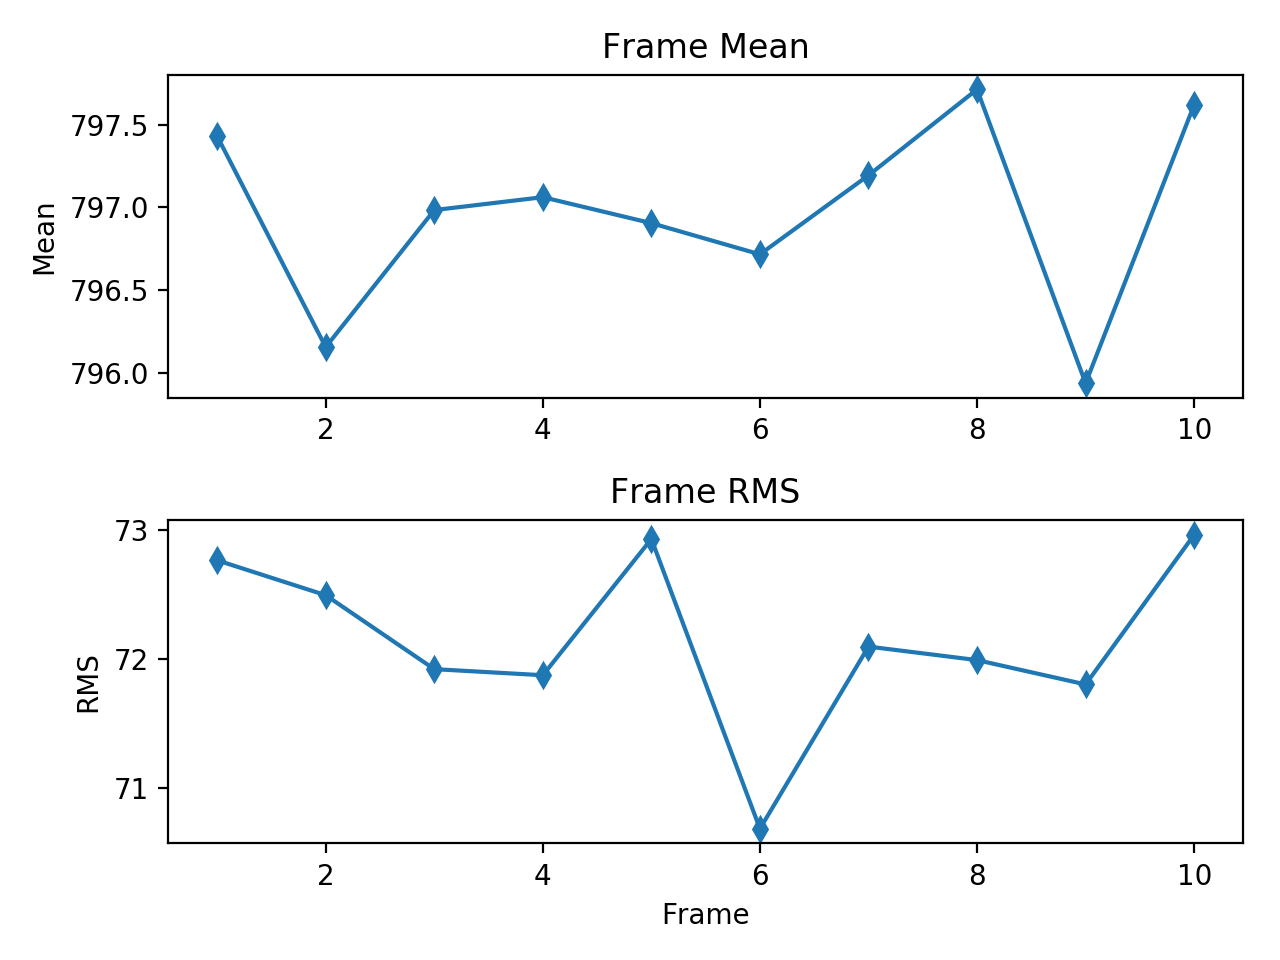

In [11]:
# some basic diagnostic plots
reload(visplot)
visplot.checkPlots(files,inter)


# Estimate mask to pixel transformation

From here on, the analysis in the same whether working with local files or the database. 

In [13]:
#get the approximate transformation (good enough for registration) with 
#the last set of x-y coordinates. This includes the mm-to-pixel transformation. 

reload(viscoords)

xm,ym,xd,yd,theta,scale = viscoords.getApproximateTransform(xlast,ylast,1)
print("Transform: xd="+str(xd)+" yd="+str(yd)+" theta="+str(theta)+" scale="+str(scale))


Transform: xd=4440.80542076 yd=2893.78502425 theta=1.56153788037 scale=14.6942265907


# Spot Registration

10 frames. Matching 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 


<IPython.core.display.Javascript object>


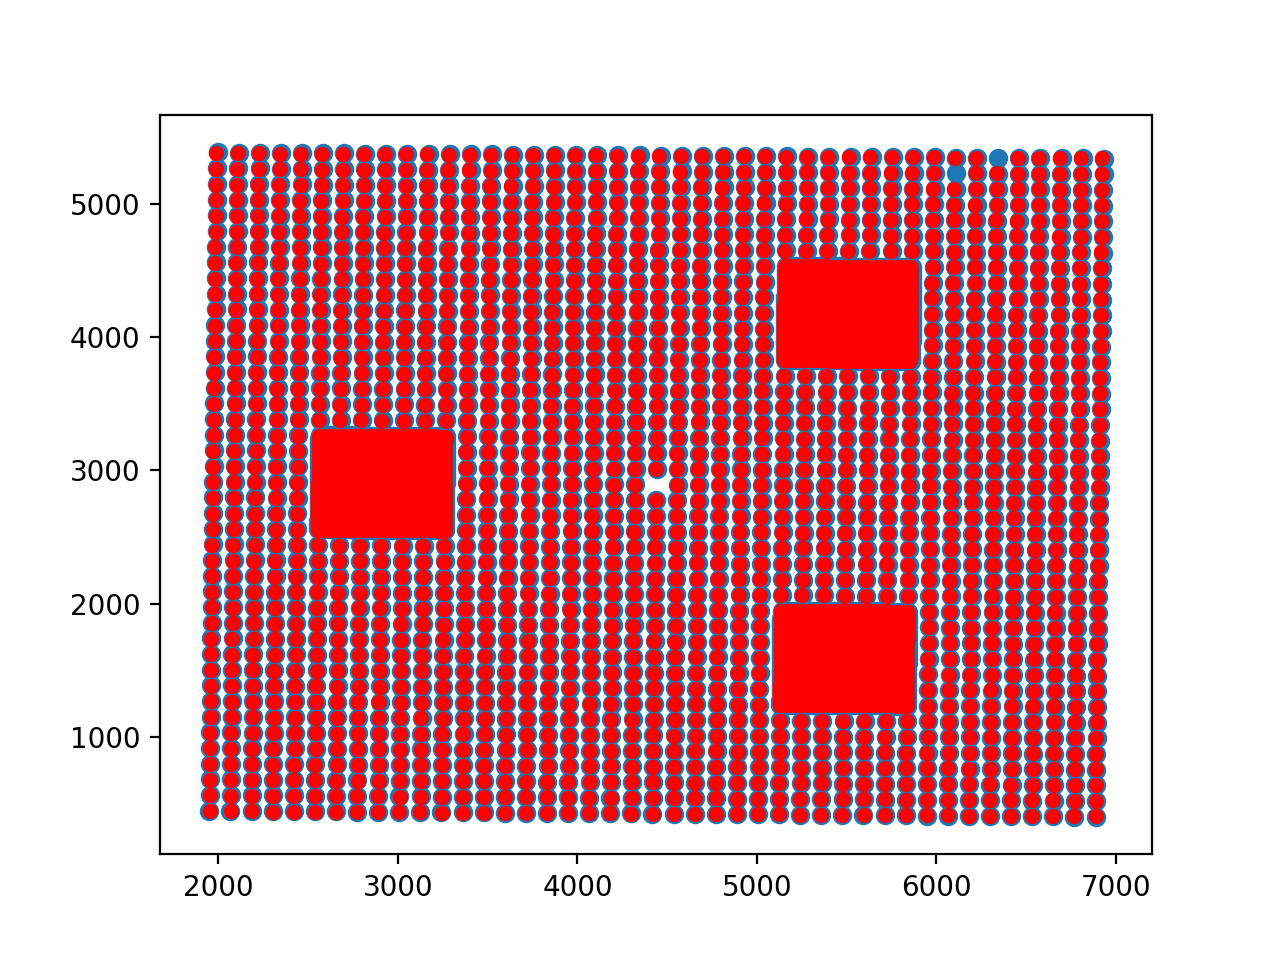

In [27]:
reload(viscoords)

#do the matching. If a point isn't matched to the mask, it will masked via 
#numpy masked arrays.
#The result is a set of data cubes of size npoints x nframes
#display the match for the first frame. 

xArray,yArray,fxArray,fyArray,backArray,peakArray = viscoords.matchAllPoints(centroids,xm,ym,tol)
visplot.checkMatched(xArray[:,0],yArray[:,0],xm,ym,prefix,inter)


# Simulated Data

For demonstration/testing purposes, as a set of data for seeing calculations is quite large. 


In [97]:
reload(viscalc)
#make fake data for plotting (because 1 set of data is ~3GB)

#nframes = 30
#avRMS = 0.5
#avShift = 2
#avScale = 1
#avRot = 0
#xArray,yArray,fxArray,fyArray,backArray,peakArray, xm, ym = viscalc.makeFakeCentroids(nframes,avRMS,avShift,avRot,avScale)
#visplot.checkMatched(xArray[:,0],yArray[:,0],xm,ym,tag)



<module 'vis_calculations' from '/Users/karr/ics_mcsActor/python/mcsActor/Visualization/vis_calculations.py'>

# Calculate Averages and RMS

In [15]:
reload(viscalc)
#calculate RMS and write to file

xAv,yAv,fxAv,fyAv,peakAv,backAv,rmsVal,nMatch = viscalc.getRMSStats(xArray,yArray,fxArray,fyArray,peakArray,backArray)


# Plots

#1 Plot of RMS as a function of position
#2 Plot of number of points sucessfully matched (of N frames)
#3 Plot of average FWHM (x) by position
#4 Plot of average FWHM (x) by position

<IPython.core.display.Javascript object>


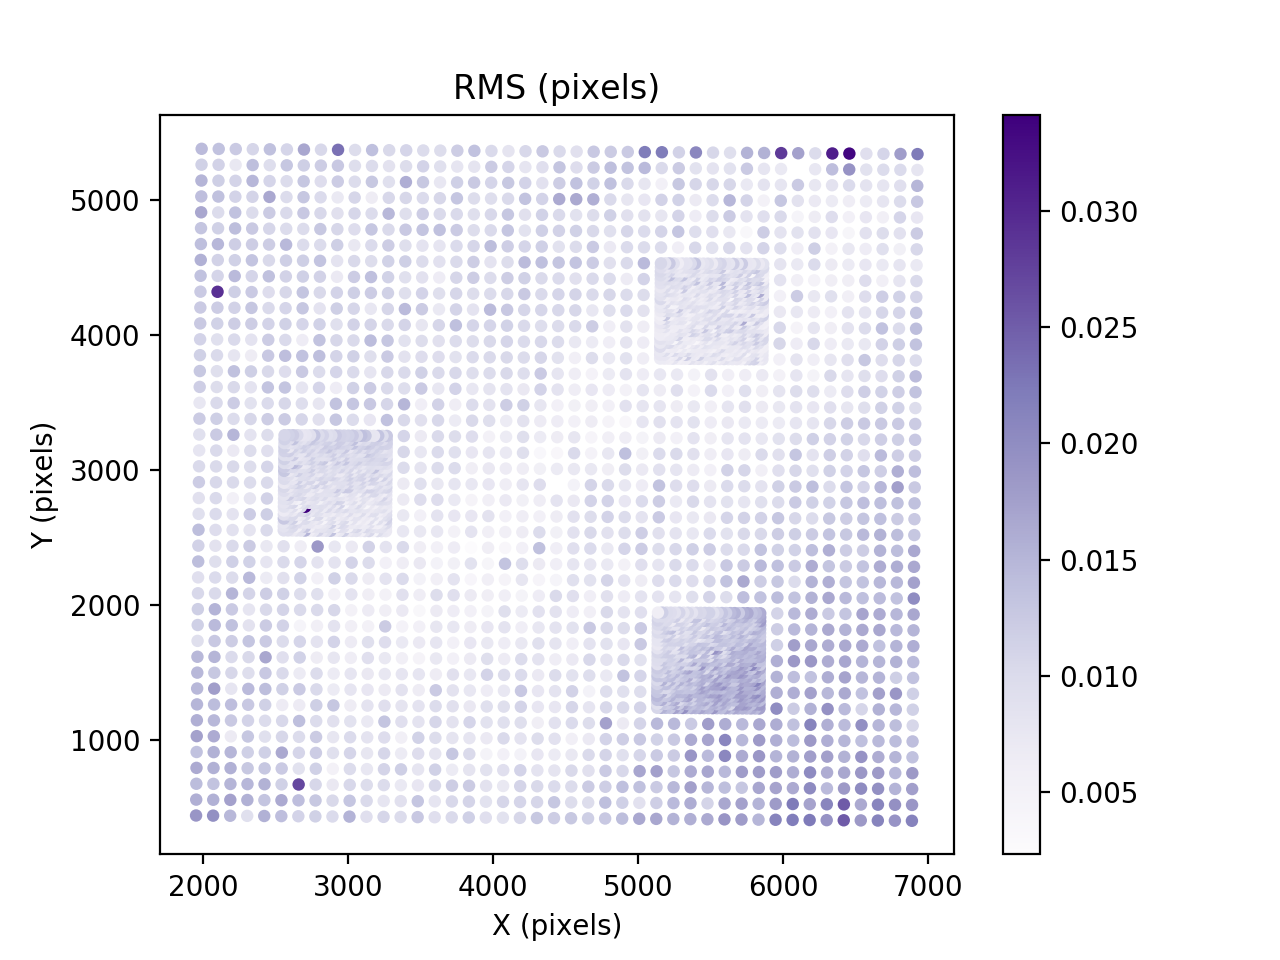

<IPython.core.display.Javascript object>


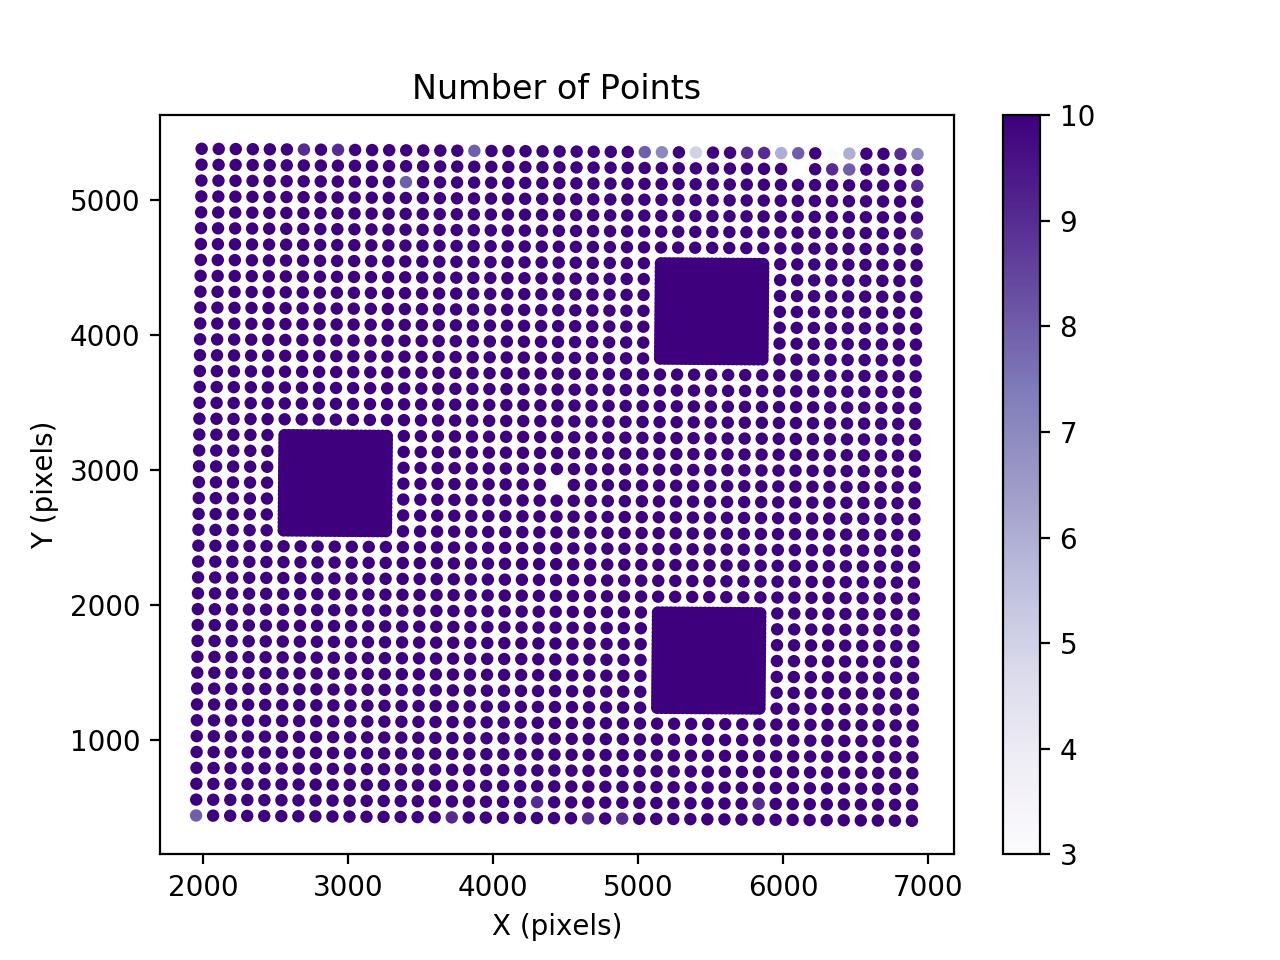

<IPython.core.display.Javascript object>


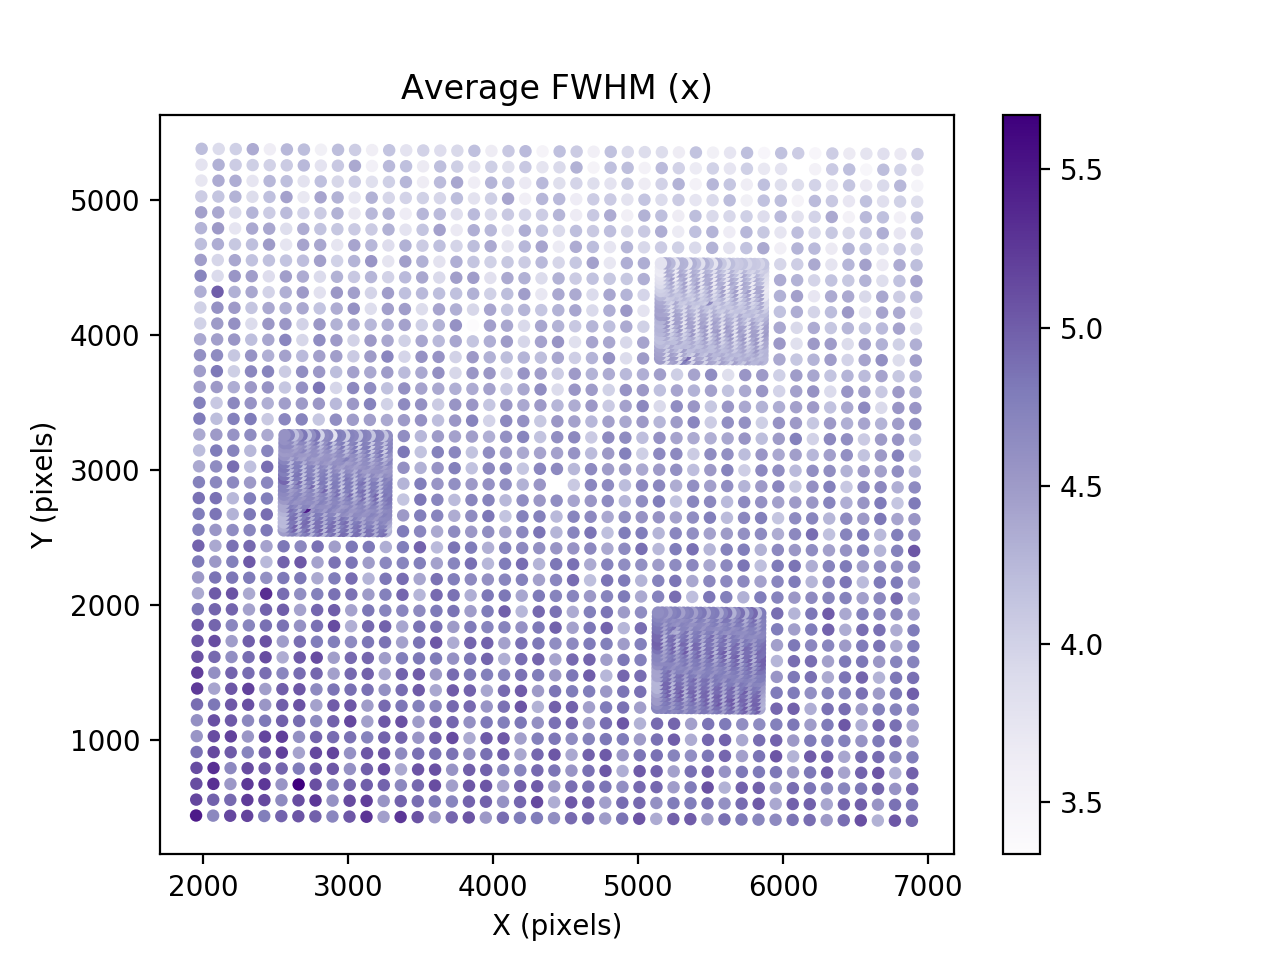

<IPython.core.display.Javascript object>


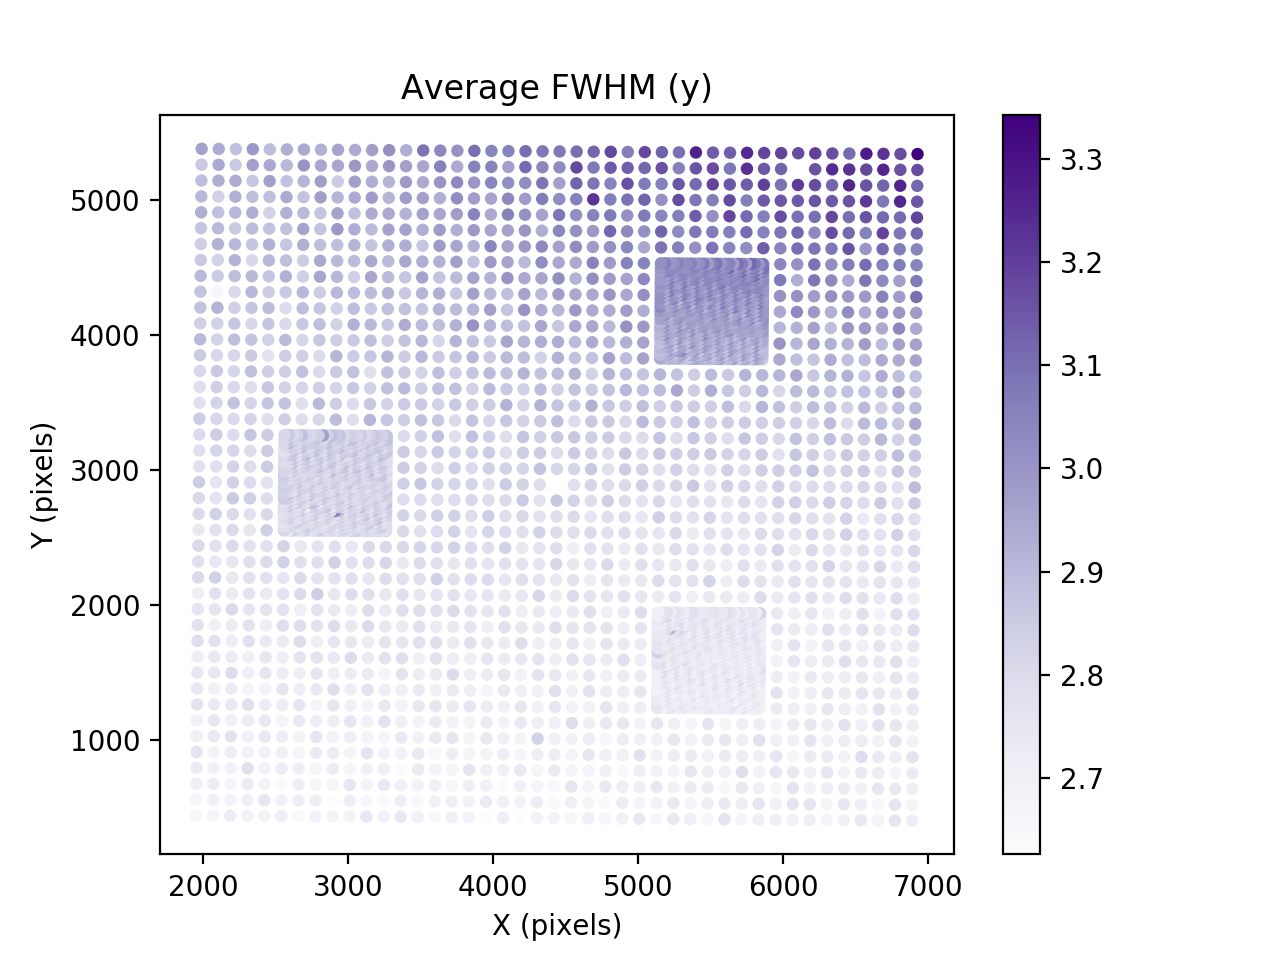

In [17]:
reload(viscalc)
reload(visplot)

plotrange=None
visplot.plotVal(xAv,yAv,rmsVal,0,plotrange,"RMS (pixels)",prefix,"rms",'pixels',inter)
visplot.plotVal(xAv,yAv,nMatch,0,plotrange,"Number of Points",prefix,"npoints",'pixels',inter)
visplot.plotVal(xAv,yAv,fxAv,0,plotrange,"Average FWHM (x)",prefix,"_fwhmxav",'pixels',inter)
visplot.plotVal(xAv,yAv,fyAv,10,plotrange,"Average FWHM (y)",prefix,"_fwhmyav",'pixels',inter)



In [19]:
reload(viscalc)
reload(viscoords)
#get transformation by frame


xdAll,ydAll,sxAll,syAll,rotAll,fxFrameAv,fyFrameAv,peakFrameAv,transAll = viscalc.getTransByFrame(xArray,yArray,fxArray,fyArray,peakArray,xm,ym)


<IPython.core.display.Javascript object>


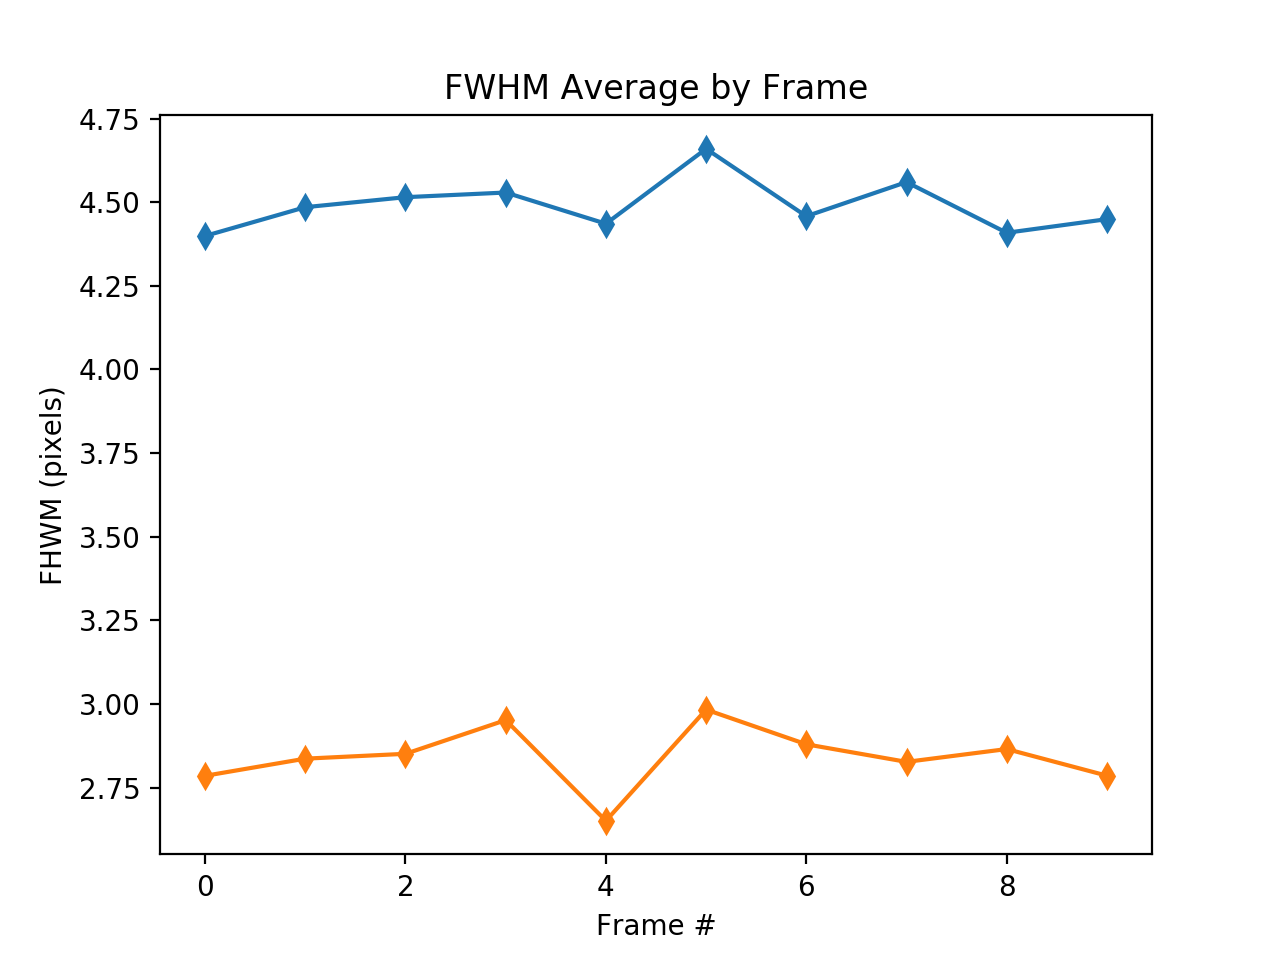

<IPython.core.display.Javascript object>


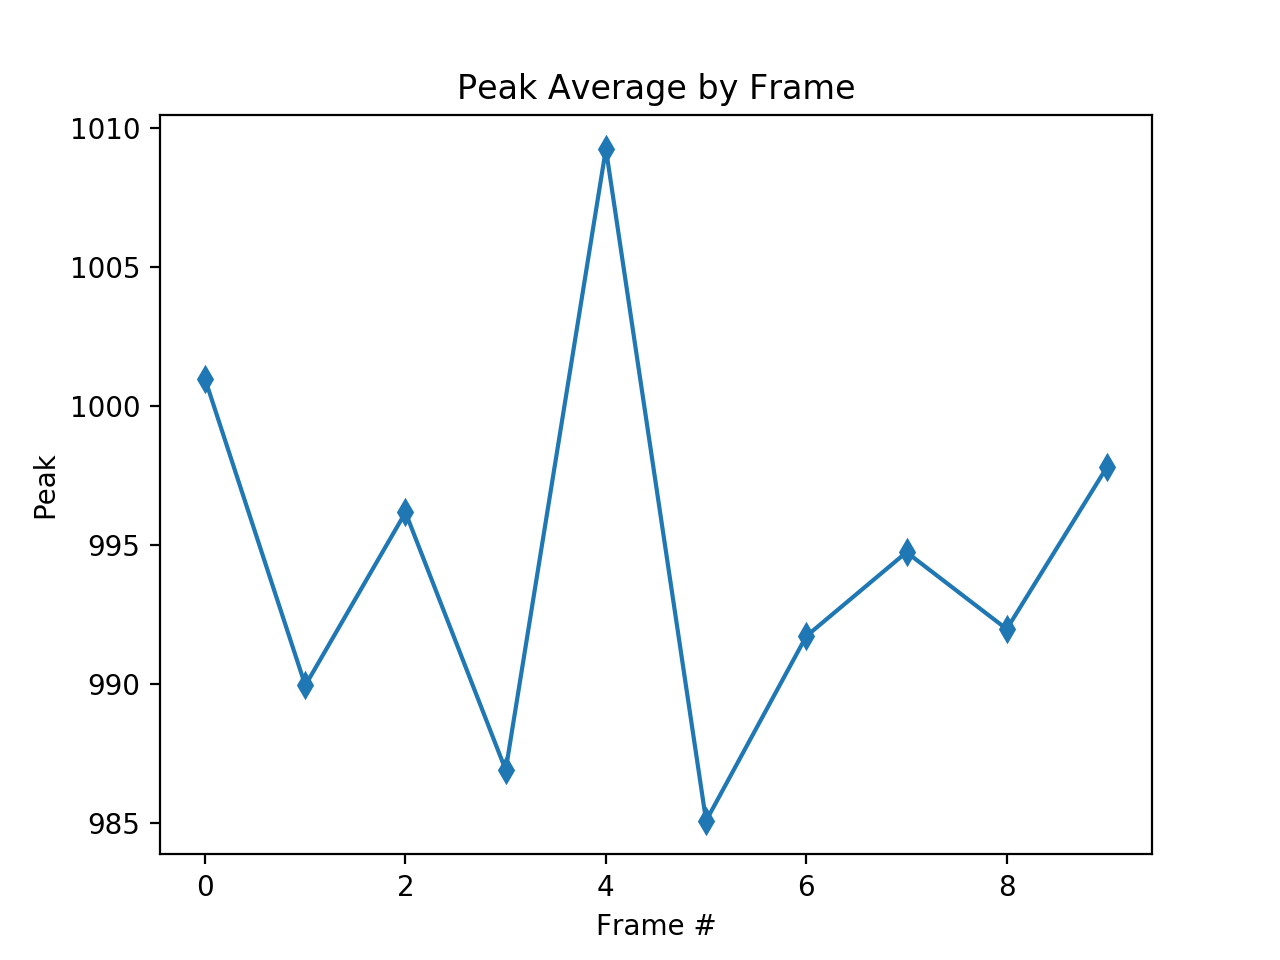

<IPython.core.display.Javascript object>


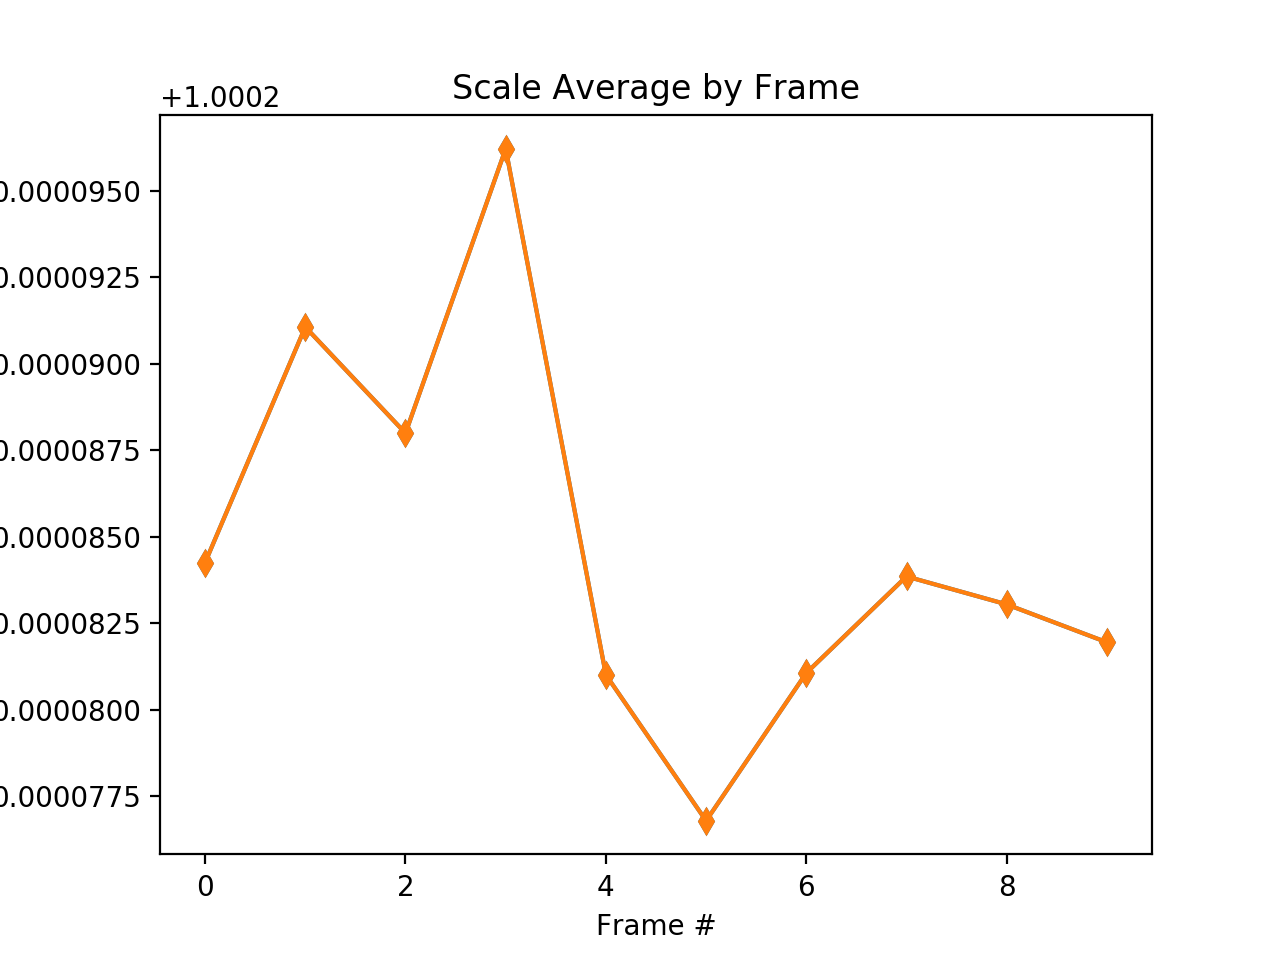

<IPython.core.display.Javascript object>


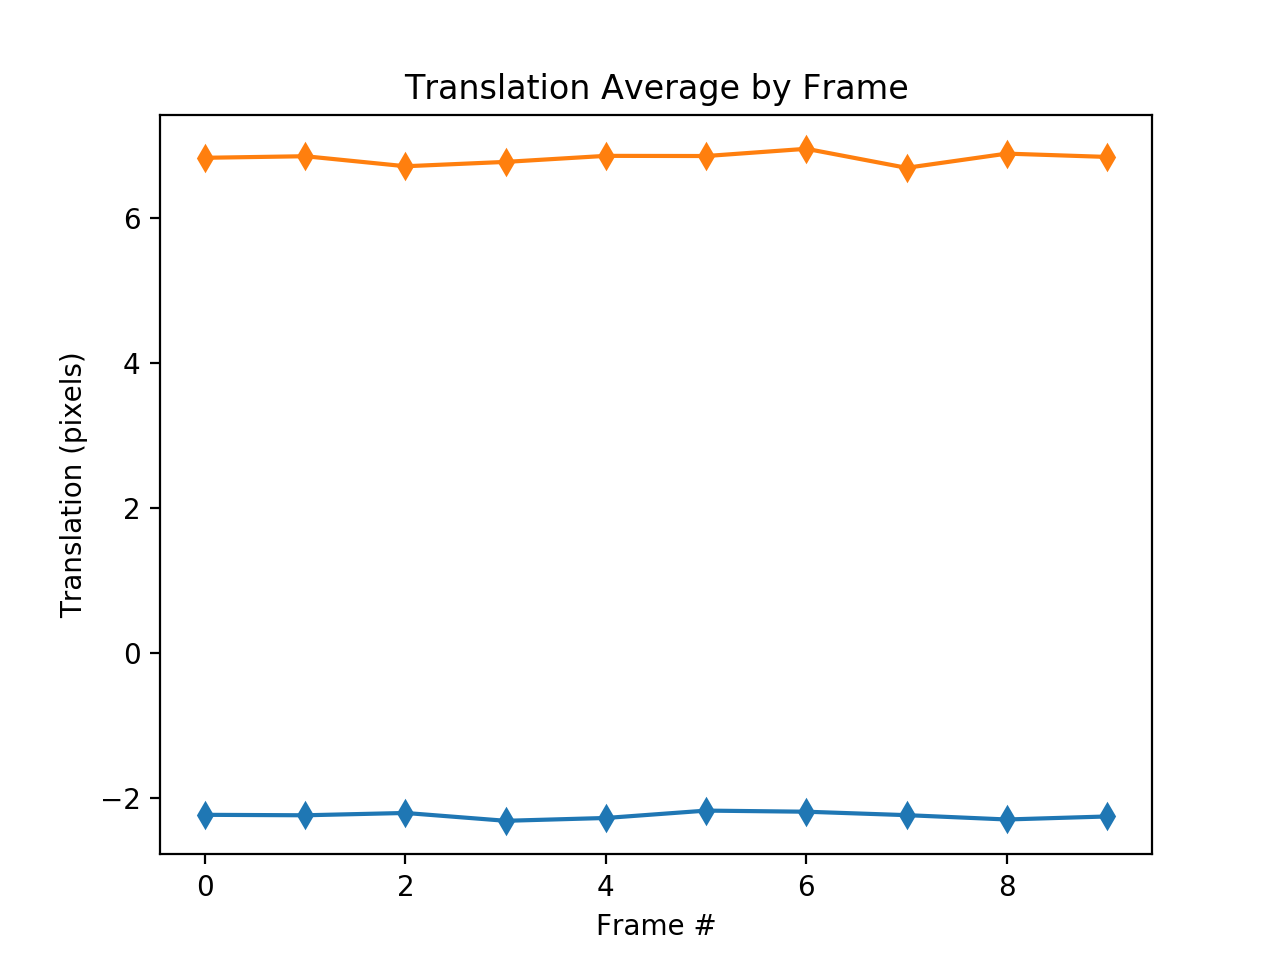

<IPython.core.display.Javascript object>


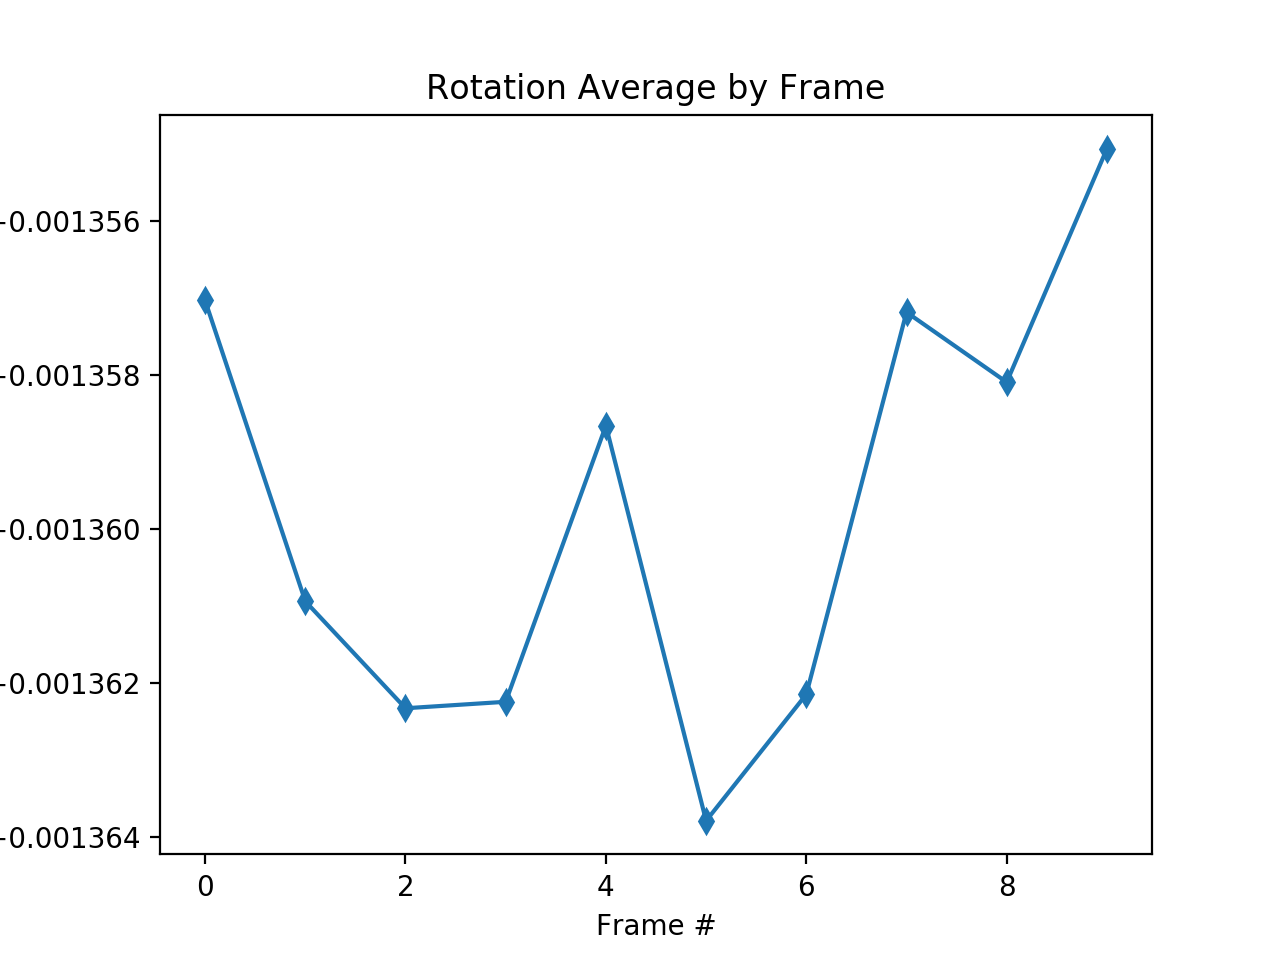

In [20]:

reload(visplot)
visplot.plotTransByFrame(fxFrameAv,fyFrameAv,peakFrameAv,sxAll,syAll,xdAll,ydAll,rotAll,prefix,inter)

In [102]:
#the average RMS for the whole set

print(rmsVal.mean())


0.0117849587921


# File IO

Dump the important variables to a yaml file that can be read in later when comparing different sets of data. This puts the listed variable into a dictionary and writes to file, the routine visio.seeingLoad(prefix,i) will load the appropriate file back. 

In [25]:
reload(visio)

visio.seeingSave(prefix,files,frameIDs,xArray,yArray,fxArray,fyArray,peakArray,backArray,xm,ym,xAv,yAv,fxAv,fyAv,peakAv,backAv,rmsVal,nMatch,fxFrameAv,fyFrameAv,peakFrameAv,transAll)


In [ ]:
dataStruct=visio.seeingLoad(prefix,0)

# Backup Code

Backup for getting approximate transformation from three matched points


In [ ]:

#first set of points is from image, second set from mask.
#format is [[x1,x2,x3],[y1,y2,y3],[1,1,1]]

m1=[[5765.1,8520.0,4424.0],[7410.0,3314.4,559.6],[1,1,1]]
m2=[[336,0,0],[0,0,336],[1,1,1]]

M=np.matrix(m1)*np.linalg.inv(np.matrix(m2))

viscalc.getCentre(M[0:2,:])
